#Aprendizaje Supervisado utilizando PCA y KMeans

**Pasos a seguir:**

1. Descarga del Set de Datos.
2. Curacion (Recetas TP Exploración y Curación).
3. Generacion de Features.
4. Reducción de dimensionalidad.
5. Aprendizaje No Supervizado.
6. Presentacion de Resultados.

**Tareas:**

  - Respecto a la reduccion de dimensionalidad, utilizando PCA, considere al menos dos escenarios de representatividad de los datos via su varianza (*explained\_variance*). Utilice una representatividad del 80% y una superior al 95%, que impacto tiene esta eleccion en los algoritmos de aprendizaje no supervizado?
- Aplique la serie de pasos en 2 de las recetas que haya elaborado en el practico de Curación y Visualización.
- Observa alguna clase de separacion para el set de datos que tenemos? 
- Sabemos de antemano que tendriamos 2 centros de acumulacion naturales, si los pensamos como Verde/No-Verde. Pero si lo pensamos en terminos estacionales, tendriamos 4 (u 8). Considera alguna otra opción?
- EXTRA: En el caso que sus resultados no sean directamente mapeables a tipo de espacio y/o estacionalidad, es capaz de identificar que esta separando el algoritmo? (Ejemplo, zonas densamente pobladas vs zonas no pobladas), esto puede requerir que asigne los puntos sobre un raster.
      
- Cambio algo haber reducido las dimensiones? 


**Lineamientos Generales KMeans**

- Explorar distintas soluciones de clustering, particularmente, iteraciones, número de clusters (considere el método de Elbow para la cantidad "optima" de clusters), métricas de distancia (comente sobre las diferencias) y cualquier otra que considere relevante (tenga en cuenta que los metodos de este estilo suelen ser sensibles a las condiciones iniciales). Para el modelo seleccionado:

- Calcular las métricas pertinentes sobre los clusters resultantes.
- Tomar ejemplos aleatorios y pensar por qué están en un cluster y no en otro.
- Contrastar la clasificación en clusters con las etiquetas de clases, tanto gráficamente como analítica. 
- Dada la naturaleza del problema, puede pensar en elaborar una matriz confusion para presentar parte de la solución, cuales clases utilizaria?

##Resolución:



Utilizaremos los conjuntos de datos generados a partir de las Recetas A y D y que fueron utilizados también para el trabajo practico de Aprendizaje Supervisado. Recordemos que estos dataset se obtuvieron a partir de dos conjuntos de datos, uno para espacios verdes y otro para espacios no verdes, a los cuales se le aplicaron de igual forma el preprocesamiento marcado por cada una de las recetas y luego fueron unidos para poner en marcha los algoritmos de Aprendizaje Supervisado elegidos.

  * Receta A:
* Leer los datos.
* Extraer las columnas de interes.
* Desechar valores nulos.
* Filtrar por nubosidad < 10%.
* Remocion de Outliers (a nivel general sin considerar estacionalidad).
* Grabar los datos transformados.

  * Receta D:
* Leer los datos.
* Extraer las columnas de interes.
* Remoción de Outliers (a nivel estacional - SIN refinar por año).
* Imputar valores nulos (definir el criterio, o estadistico, media, mediana, etc).
* Filtrar por nubosidad:
< 40%
* NORMALIZACION.
* Grabar los datos transformados.

Por otro lado, estos dataset cuentan con el agregado de features extras como año, mes y target. Como estamos en un contexto de Aprendizaje NO supervisado, esta última variable será considerada como una variable categórica más.

###Carga de datos (curados y preprocesados)

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import random

from sklearn.cluster import KMeans #,MeanShift
from sklearn import decomposition

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from yellowbrick.cluster import SilhouetteVisualizer 

from sklearn.metrics import silhouette_score




In [ ]:
!gdown https://drive.google.com/file/d/1tH9oqyL2KtNerYWH8012raDla7iko7jL/view?usp=sharing --fuzzy
file_name1 = 'df_A_modelo_encode.csv'
df_A= pd.read_csv(file_name1)

Downloading...
From: https://drive.google.com/uc?id=1tH9oqyL2KtNerYWH8012raDla7iko7jL
To: /content/df_A_modelo_encode.csv
100% 49.6M/49.6M [00:00<00:00, 163MB/s]


In [ ]:
!gdown https://drive.google.com/file/d/1tI7pc0yVTkHK5sBuK4M0CEyEoPoj-ATS/view?usp=sharing --fuzzy
file_name2 = 'df_C_modelo_encode.csv'
df_C= pd.read_csv(file_name2) #cargamos el dataset de la receta C, para luego hacer un escalado incluyendo las variables temporales

Downloading...
From: https://drive.google.com/uc?id=1tI7pc0yVTkHK5sBuK4M0CEyEoPoj-ATS
To: /content/df_C_modelo_encode.csv
100% 61.7M/61.7M [00:00<00:00, 135MB/s]


In [ ]:
df_A.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,target,año,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
count,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,1.700900e+05,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000
mean,0.364385,1.051277,1.045381,0.191310,0.994003,0.053580,0.125309,0.269195,0.241356,0.416255,1.885898e+04,0.692545,2019.393245,6.559433,0.209413,0.239567,0.273808,0.277212
std,0.128667,0.231609,0.215483,0.049479,0.112413,0.081421,0.033215,0.042451,0.040652,1.476307,6.864772e+04,0.461441,1.397456,3.620712,0.406891,0.426821,0.445913,0.447623
min,-0.009102,0.254644,0.308995,0.034613,0.638591,-0.206024,0.042400,0.119800,0.107700,0.000000,4.225951e+02,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258850,0.877130,0.882758,0.161540,0.913383,-0.008449,0.100000,0.236300,0.212500,0.000000,2.929467e+03,0.000000,2018.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351721,1.044740,1.045812,0.194309,0.975294,0.043326,0.123250,0.269200,0.239700,0.000000,6.336731e+03,1.000000,2019.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,0.465916,1.200434,1.194116,0.223182,1.064357,0.110543,0.148100,0.300400,0.269400,0.000000,3.136548e+04,1.000000,2021.000000,10.000000,0.000000,0.000000,1.000000,1.000000
max,0.747038,1.770667,1.744506,0.328613,1.400520,0.325748,0.248600,0.403100,0.373200,9.826493,1.370630e+06,1.000000,2022.000000,12.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_C.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,target,año,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
count,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,2.099750e+05,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000
mean,0.360393,1.056179,1.048979,0.186304,0.995806,0.055157,0.127558,0.271164,0.242459,3.906942,1.868400e+04,0.697412,2019.470213,6.445096,0.221245,0.233175,0.267460,0.278119
std,0.129677,0.249764,0.229699,0.053963,0.125364,0.082092,0.034765,0.042764,0.041735,8.843725,6.888406e+04,0.459380,1.407488,3.600756,0.415086,0.422854,0.442636,0.448073
min,-0.009102,-0.038760,0.299199,-0.048641,0.474378,-0.146854,0.042400,0.136800,0.093400,0.000000,4.225951e+02,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250544,0.878140,0.888130,0.159433,0.911408,-0.008313,0.102100,0.238300,0.213100,0.000000,2.928527e+03,0.000000,2018.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.349143,1.046311,1.047573,0.192141,0.974401,0.046276,0.125800,0.271500,0.240900,0.000000,6.128520e+03,1.000000,2020.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,0.463446,1.205720,1.199225,0.218981,1.064299,0.113271,0.150400,0.301800,0.270200,0.533689,3.136548e+04,1.000000,2021.000000,10.000000,0.000000,0.000000,1.000000,1.000000
max,0.762083,2.071175,1.973077,0.369972,1.656963,0.330231,0.287400,0.404600,0.395550,37.477434,1.370630e+06,1.000000,2022.000000,12.000000,1.000000,1.000000,1.000000,1.000000


###Generación de features extras

In [ ]:
df_A['date'] = pd.to_datetime(df_A.date, format='%Y/%m/%d')
df_C['date'] = pd.to_datetime(df_C.date, format='%Y/%m/%d')

Generamos la columna estación como variable cualitativa para realizar más adelante tablas de contingencia.

In [ ]:
#le asignamos a cada fecha la estación del año correspondiente.
from datetime import date, datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Otoño': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Invierno': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Primavera': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Primavera']:
        return 'Primavera'
    if date in seasons['Invierno']:
        return 'Invierno'
    if date in seasons['Otoño']:
        return 'Otoño'
    else:
        return 'Verano'

# Assuming df has a date column of type `datetime`
df_A['estacion'] = df_A.date.map(season_of_date)
df_C['estacion'] = df_C.date.map(season_of_date)

Como nuestros dataset tienen incluidas variables temporales, sólo se generará la columna 'week' basada en el número de la semana del año. Esta variable toma 53 valores distintos.


In [ ]:
#función que agrega el número de la semana del año a partir de la columna de fechas ('date')
def prc_dates(df,col='date',drop_col=True):

  #df[col]=pd.to_datetime(df[col])
  df['week']=df[col].apply(lambda x:float(x.strftime('%U')))
  #df.drop('target',axis=1,inplace=True)
  if drop_col:
    df.drop(col,axis=1,inplace=True)
  return df

In [ ]:
df_A_pca= df_A.copy()
df_D_pca= df_C.copy()
df_A_pca= prc_dates(df_A_pca)
df_D_pca= prc_dates(df_D_pca)

Renombramos la variable 'target' como 'espacio' haciendo referencia a espacios verdes y no verdes como herramienta para realizar interpretaciones de los clusters obtenidos.

In [ ]:
df_A_pca=df_A_pca.rename(columns={'target':'espacio'})

In [ ]:
df_D_pca=df_D_pca.rename(columns={'target':'espacio'})

In [ ]:
#columnas de interés receta A

col_A= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median', 'mes', 'week','año','area_m2']

#'raster', 'clouds_on_raster', 

#columnas de interés receta D

col_D= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes','estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera',
        'estacion_Verano','area_m2','week']
#'raster', 'clouds_on_raster', 'area_m2'

In [ ]:
df_D_pca1=df_D_pca.copy()
df_D_pca1=df_D_pca1.drop(labels='año', axis=1)

Preparamos el dataset de la receta D: Normalización

In [ ]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
df_D_escal=df_D_pca1.copy()
df_D_escal.loc[:,col_D]=transformer.fit_transform(df_D_escal[col_D])

In [ ]:
df_D_escal.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,espacio,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,week
count,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000
mean,0.052838,0.030122,0.004519,-0.098033,0.140001,0.073043,0.036399,-0.005286,0.027300,3.906942,0.441520,0.697412,-0.079272,0.221245,0.233175,0.267460,0.278119,-0.009734
std,0.609094,0.762451,0.738355,0.906206,0.819951,0.675189,0.719767,0.673456,0.730911,8.843725,2.422343,0.459380,0.514394,0.415086,0.422854,0.442636,0.448073,0.562644
min,-1.682682,-3.312377,-2.405609,-4.043457,-3.270445,-1.588449,-1.726708,-2.121259,-2.583187,0.000000,-0.200652,0.000000,-0.857143,0.000000,0.000000,0.000000,0.000000,-0.928571
25%,-0.463120,-0.513375,-0.512523,-0.549272,-0.412012,-0.448985,-0.490683,-0.522834,-0.486865,0.000000,-0.112529,0.000000,-0.571429,0.000000,0.000000,0.000000,0.000000,-0.535714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.536880,0.486625,0.487477,0.450728,0.587988,0.551015,0.509317,0.477166,0.513135,0.533689,0.887471,1.000000,0.428571,0.000000,0.000000,1.000000,1.000000,0.464286
max,1.939581,3.128582,2.974983,2.986321,4.464358,2.335464,3.345756,2.096062,2.708406,37.477434,47.983402,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,0.928571


##Receta A

###PCA Receta A

Primero vamos a mostrar por qué es necesario prescindir de la variable área_m2 en el intento de buscar conglomerados significativos. Si incluimos esta variable vamos a ver que la primera componente PC1 se lleva el 100% de la varianza explicada de nuestros datos, cuando observamos el peso que la variable relacionada al área de los espacios tiene sobre esta componente principal nos encontramos que al fin y al cabo 'area_m2' se lleva todo el protagonismo. Esto nos está diciendo que con conocer sólo los valores de esta feature bastaría para formar conglomerados, lo cual no es cierto.

A continuación se muestran los gráficos que sostienen esta afirmación y por lo cual decidimos quitarla del conjunto de variables que incluiremos en el algoritmo KMeans.

In [ ]:
X_a=df_A_pca[col_A]

In [ ]:
pca=decomposition.PCA(n_components=6) #elegimos hasta 6 componentes pero pueden ser más

In [ ]:
#PCA con la variable área
pca_a=pca.fit(X_a) 

# proporción de varianza
print('proporción de varianza por componente: ', pca_a.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca_a.explained_variance_ratio_.cumsum())

X_projected_a=pca_a.transform(X_a) #numpy array
print ('tamaño de los datos: ', X_projected_a.shape)

proporción de varianza por componente:  [9.99999944e-01 5.58278304e-08 4.03606903e-10 2.39549857e-11
 1.87422621e-11 2.94343177e-12]
proporción de varianza por componente acumulada:  [0.99999994 1.         1.         1.         1.         1.        ]
tamaño de los datos:  (170090, 6)


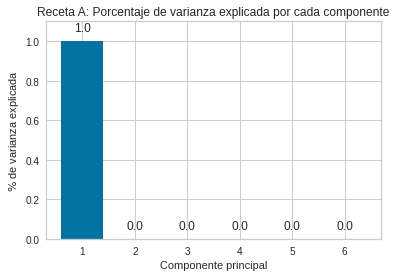

In [ ]:
# Gráfico de barras: porcentaje de varianza explicada por cada componente
# ==============================================================================
# print('----------------------------------------------------')
# print('Porcentaje de varianza explicada por cada componente')
# print('----------------------------------------------------')
# print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_a.n_components_) + 1,
    height = pca_a.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_a.columns)) + 1, pca_a.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_a.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Receta A: Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('$\%$ de varianza explicada');

El gráfico de barras muestra que efectivamente la primera componente explica practicamente el $100\%$ de la varianza de los datos. 


Recordemos que cada componente principal $\left(Z_i\right)$ se obtiene por combinación lineal de las variables originales. Se pueden entender como nuevas variables obtenidas al combinar de una determinada forma las variables originales. La primera componente principal de un grupo de variables $\left(X_1, X_2, \ldots, X_p\right)$ es la combinación lineal normalizada de dichas variables que tiene mayor varianza:
$$
Z_1=\phi_{11} X_1+\phi_{21} X_2+\ldots+\phi_{p 1} X_p
$$
Que la combinación lineal sea normalizada implica que:
$$
\sum_{j=1}^p \phi_{j 1}^2=1
$$
Los términos $\phi_{11}, \ldots, \phi_{1 p}$ reciben en el nombre de loadings y son los que definen las componentes. Por ejemplo, $\phi_{11}$ es el loading de la variable $X_1$ de la primera componente principal. Los loadings pueden interpretarse como el peso/importancia que tiene cada variable en cada componente y, por lo tanto, ayudan a conocer que tipo de información recoge cada una de las componentes.

En nuestro paso $p=13$ e $i=6$, ya que elegimos 6 componentes principales y 13 variables en la lista col_A. Si en la siguiente tabla observamos la columna correspondiente a 'area_m2', el peso que esta variable tiene en la combinación lineal para formar PC1 es de 1, por lo que el resto de las variables serían innecesarias (al igual que el resto de las componentes principales).

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = pca_a.components_,
    columns = df_A_pca[col_A].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']
)

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,week,año,area_m2
PC1,-6.588383e-08,2.973923e-08,4.662982e-08,-5.450799e-08,-3.026727e-08,-2.100417e-08,4.535952e-09,-2.823662e-08,-1.818294e-08,3.256752e-07,0.000001,3.480353e-09,1.000000e+00
PC2,2.081060e-03,3.724034e-03,3.600215e-03,-2.646284e-05,-1.830475e-03,1.788555e-03,-5.247007e-04,1.262400e-04,-7.384836e-04,-2.225043e-01,-0.974811,1.401017e-02,1.432757e-06
PC3,-2.625051e-04,2.701343e-03,2.443910e-03,-3.303893e-04,-1.917729e-03,-4.201082e-03,-1.332340e-03,-2.595543e-03,-5.326817e-04,9.523309e-03,-0.016528,-9.997963e-01,2.299220e-08
PC4,-2.320199e-01,-6.583006e-01,-6.133825e-01,-5.593098e-02,3.094925e-01,-1.433755e-01,8.009327e-02,2.503600e-02,9.275630e-02,3.521833e-02,-0.014308,-2.838964e-03,4.673967e-08
PC5,-2.632742e-02,3.485140e-02,2.992964e-02,-1.117661e-03,-1.603373e-02,-1.814554e-02,3.137685e-03,-8.857787e-03,5.431394e-04,9.732230e-01,-0.221770,1.323639e-02,-1.283170e-08
PC6,-8.025906e-01,1.943959e-01,1.471669e-01,-9.035469e-02,-8.043546e-02,-4.227398e-01,8.506691e-02,-2.984113e-01,-6.922663e-02,-4.347908e-02,0.008889,3.193300e-03,-9.008778e-08


Ahora construimos un dataset cuyas columnas sean las componentes principales obtenidas por PCA. Este nuevo conjunto de datos será sometido al algoritmo KMean para sacar conclusiones necesarias para comprender el comportamiento de nuestro conjunto de datos.

In [ ]:
# Proyección de las observaciones
# ==============================================================================
proyecciones_df_a = pd.DataFrame(
    X_projected_a,
    columns =  ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'],
    index   = X_a.index
)
proyecciones_df_a.head(5)

#La transformación es el resultado de multiplicar los vectores que definen cada componente con el valor de las variables

,PC1,PC2,PC3,PC4,PC5,PC6
0,-14208.267582,25.723186,2.756555,-0.244350,0.150874,-0.090870
1,-17356.977102,25.716689,2.754957,0.093489,0.134560,-0.184031
2,-16854.785087,25.717397,2.754882,0.099485,0.134331,-0.181836
3,-11918.469974,25.724793,2.754772,0.059634,0.132460,-0.264077
4,-14271.621567,25.720602,2.754637,0.174676,0.131676,-0.191368


Agregamos las columnas espacio (verde/no verde) y estacion para analizar resultados de KMeans.

In [ ]:
proyecciones_df_a['espacio']=df_A_pca['espacio']
proyecciones_df_a['estacion']=df_A_pca['estacion']

In [ ]:
proyecciones_df_a.sample(10)

,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion
55556,-13702.896951,-13.295678,0.213709,-0.120478,0.497909,-0.095970,1,Primavera
134675,12506.507295,22.862916,0.706192,0.070025,-0.503520,-0.108911,0,Verano
102818,-9597.034314,-14.238959,-1.803688,0.248655,0.288619,-0.074437,1,Primavera
14614,-10339.363918,19.670682,1.666325,-0.163631,-0.203253,-0.186062,1,Verano
73573,-15352.506683,5.378934,-0.533399,-0.706810,-0.329795,0.144253,1,Otoño
26368,-14269.490143,-9.192244,1.268880,0.450747,0.385348,0.083357,1,Invierno
38594,-15798.222290,22.824242,0.706837,-0.237358,-0.493641,-0.139945,1,Verano
72470,-7064.400965,6.364618,-0.517177,-0.521418,-0.115267,0.122993,1,Otoño
163191,12506.507342,-10.085324,-1.745876,0.206894,0.211932,0.113675,0,Invierno
32194,-17734.218269,-20.359636,1.107647,-0.487684,-0.088512,-0.198683,1,Primavera


Graficamos utilizando las dos primeras componentes principales.

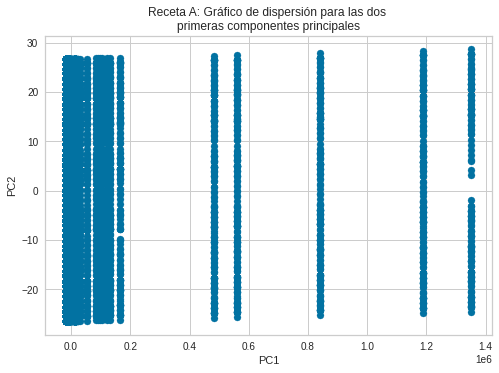

In [ ]:
plt.scatter(X_projected_a[:,0], X_projected_a[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Receta A: Gráfico de dispersión para las dos \nprimeras componentes principales')
plt.show()

###KMeans receta A: con variable area_m2

**Ebowl**

Con este método se evalúan las particiones realizadas mediante KMeans usando la inercia (suma de las distancias al cuadrado de las muestras a su centro de conglomerado más cercano). La idea es que al variar el número de clúster K en el modelo, el valor de la distancia media de los datos al centroide más cercano va a variar. 

Graficamos esa curva para elegir el número de particiones óptimos con el metodo del codo.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

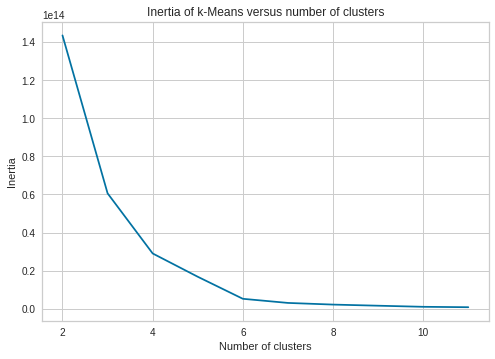

In [ ]:
#Ebowl
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i,random_state=10).fit(X_projected_a).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

El método del codo nos dice que podríamos comenzar con un $k=3$ o $k=4$. 

In [ ]:
#Algoritmo KMeans
n_clust =3 #Se selecciona el número de clusters (k)

km = KMeans(n_clusters=n_clust, random_state=10)
km_a=km.fit(proyecciones_df_a[['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']]) 

clusters = km_a.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_a=proyecciones_df_a.copy() #Se hace una copia del df 
df_clusters_a['kmeans_clust'] = km_a.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km_a.labels_)+1, 'clusters')
df_clusters_a.head(5)

Nro Clusters encontrados:  3 clusters


,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion,kmeans_clust
0,-14208.267582,25.723186,2.756555,-0.244350,0.150874,-0.090870,1,Verano,0
1,-17356.977102,25.716689,2.754957,0.093489,0.134560,-0.184031,1,Verano,0
2,-16854.785087,25.717397,2.754882,0.099485,0.134331,-0.181836,1,Verano,0
3,-11918.469974,25.724793,2.754772,0.059634,0.132460,-0.264077,1,Verano,0
4,-14271.621567,25.720602,2.754637,0.174676,0.131676,-0.191368,1,Verano,0


**Gráfico de los cluster encontrados con KMeans**

In [ ]:
# Predicting the clusters
labels = km_a.predict(proyecciones_df_a[['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']])
# Getting the cluster centers
C = km_a.cluster_centers_

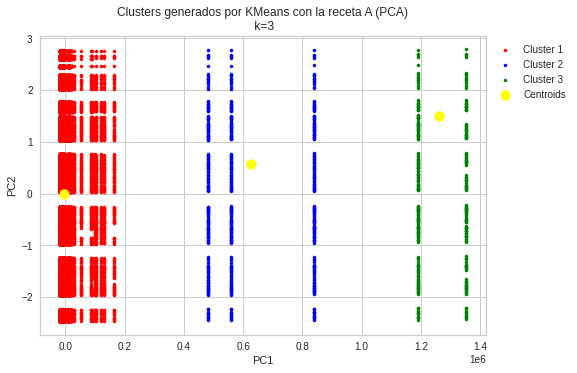

In [ ]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_a.iloc[labels == 0, 0], df_clusters_a.iloc[labels == 0, 2], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_a.iloc[labels == 1, 0], df_clusters_a.iloc[labels == 1, 2], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(df_clusters_a.iloc[labels == 2, 0], df_clusters_a.iloc[labels == 2, 2], s = 10, c = 'green', label = 'Cluster 3')
# plt.scatter(df_clusters_A.iloc[labels == 3, 0], df_clusters_A.iloc[labels == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta A (PCA)\n k={n_clust}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Por el análisis hecho con anterioridad estos clusters están agrupando según los valores de área de los espacios, por lo que podríamos tomar un $k$ variando de 4 a 6 y el significado de los conglomerados sería el mismo que para $k=3$ . El gráfico en 3D muestra también el mismo comportamiento.

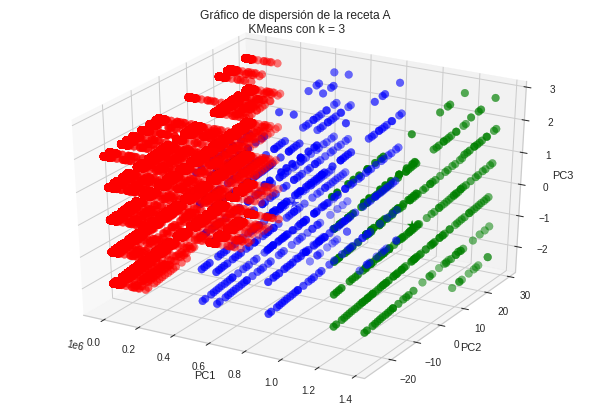

In [ ]:
# Visualizacion grafica de los clusters en 3D
colores=['red','blue','green']#'cyan','pink','brown','yellow','orange','blue','cyan'
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(proyecciones_df_a.iloc[:, 0], proyecciones_df_a.iloc[:, 1],proyecciones_df_a.iloc[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=100)
#ax.view_init(60,30) 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Gráfico de dispersión de la receta A\n KMeans con k = {n_clust}')
plt.show()

**Tablas de contingencia**

In [ ]:
#Tabla de contingencia usando la variable categórica espacio
round(pd.crosstab(df_clusters_a.kmeans_clust, df_clusters_a.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.31,0.69,0.99
1,0.00,0.00,0.00
2,0.00,0.00,0.00
All,0.31,0.69,1.00


In [ ]:
#Tabla de contingencia usando la variable categórica estación
round(pd.crosstab(df_clusters_a.kmeans_clust, df_clusters_a.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.21,0.24,0.27,0.28,0.99
1,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
All,0.21,0.24,0.27,0.28,1.00


Observando las tablas de contingencia, con el objetivo de encontrar significado a los clusters proporcionados por KMeans, vemos que efectivamente los clusters no pueden brindar información sobre la presencia o no de espacios verdes (ya que no puede diferenciarlos dentro del cluster 0) ni tampoco pueden proporcionar información sobre las observaciones según la estación del año, pues en el cluster cero hay probabilidad que haya datos de cualquier estación.

Notar que el resto de los cluster tienen probabilidad cero de observaciones, luego no tendría sentido aplicar KMeans (ni ninguna técnica de clustering).

**Métrica de evaluación**

Como métrica de evaluación vamos a utilizar el Coeficiente de Silhouette:

Sea $a(x)$ la distancia promedio de $x$ a todos los demás puntos en el
mismo clúster y $b(x)$ la distancia promedio de $x$ a todos los demás puntos en el clúster más cercano. El coeficiente de silhouette para el punto $x$ está definido como:

$$
s(x)=\frac{b(x)-a(x)}{\max \{a(x), b(x)\}}
$$

Donde el valor de $\mathrm{s}(\mathrm{x})$ puede variar entre $-1$ y $1$:
- $-1$= mal agrupamiento
- $0$ = indiferente
- $1$ = bueno

El coeficiente de Silhouette para todo el agrupamiento es :
$$
S C=\frac{1}{N} \sum_{i=1}^N s(x)
$$

$a(x)$ también se denomina cohesión y $b(x)$ es llamado separación.

La puntuación de silueta de 1 significa que los racimos son muy densos y bien separados. La puntuación de 0 significa que los clústeres se superponen. La puntuación inferior a 0 significa que los datos pertenecientes a los conglomerados pueden ser erróneos/incorrectos.


In [ ]:
# Calculate Silhoutte Score
#
score = metrics.silhouette_score(proyecciones_df_a[['PC1','PC2','PC3','PC4','PC5','PC6']], km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.975


El coeficiente de Silhoutte nos dice que la agrupación es muy buena, lo cual es lógico porque en el cluster $0$ están practicamente todas las observaciones.

**KMeans sin la variable 'area_m2'**

In [ ]:
col_A_1= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes','week','año']



PCA

In [ ]:
X_a_1=df_A_pca[col_A_1]

In [ ]:
#PCA sin la variable área
pca_a_1=pca.fit(X_a_1) 

# proporción de varianza
print('proporción de varianza por componente: ', pca_a_1.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca_a_1.explained_variance_ratio_.cumsum())

X_projected_a_1=pca_a_1.transform(X_a_1) #numpy array
print ('tamaño de los datos: ', X_projected_a_1.shape)

proporción de varianza por componente:  [9.91995781e-01 7.17137216e-03 4.25675491e-04 3.33018937e-04
 5.24437967e-05 7.91432327e-06]
proporción de varianza por componente acumulada:  [0.99199578 0.99916715 0.99959283 0.99992585 0.99997829 0.99998621]
tamaño de los datos:  (170090, 6)


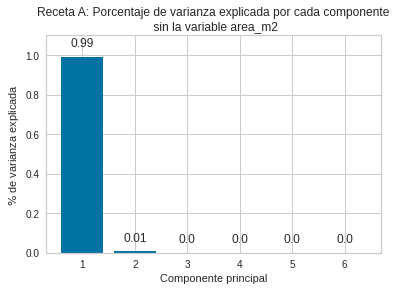

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_a_1.n_components_) + 1,
    height = pca_a_1.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_a_1.columns)) + 1, pca_a_1.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_a_1.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Receta A: Porcentaje de varianza explicada por cada componente\n sin la variable area_m2')
ax.set_xlabel('Componente principal')
ax.set_ylabel('$\%$ de varianza explicada');

Nuevamente, la variable week se lleva todo el peso de la componente principal 1, el análisis ahora es similar al realizado con la feature area_m2.

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
print('Componentes principales vistas como combinación lineal de las variables del dataset original')
pd.DataFrame(
    data    = pca_a_1.components_,
    columns = df_A_pca[col_A_1].columns,
    index   = [['PC1','PC2','PC3','PC4','PC5','PC6']]
)

Componentes principales vistas como combinación lineal de las variables del dataset original


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,week,año
PC1,0.002083,0.003723,0.003599,-0.000025,-0.001830,0.001789,-0.000525,0.000127,-0.000738,-0.222504,-0.974811,0.014010
PC2,-0.000259,0.002699,0.002441,-0.000327,-0.001916,-0.004200,-0.001333,-0.002594,-0.000532,0.009523,-0.016527,-0.999796
PC3,-0.231854,-0.658317,-0.613434,-0.055815,0.309532,-0.143315,0.080076,0.025097,0.092787,0.035115,-0.014283,-0.002838
PC4,-0.026414,0.034780,0.029876,-0.001165,-0.016012,-0.018184,0.003153,-0.008877,0.000543,0.973224,-0.221772,0.013236
PC5,-0.802667,0.193827,0.147351,-0.092107,-0.080714,-0.422305,0.085071,-0.298413,-0.069511,-0.043538,0.008900,0.003186
PC6,-0.097596,-0.121782,-0.007187,0.951038,-0.240577,-0.074624,0.034365,0.052935,0.060716,-0.001956,-0.000022,-0.000092


Notar que el peso de week en la primera componente es $0.97$ en valor absoluto.

In [ ]:
# Proyección de las observaciones
# ==============================================================================
proyecciones_df_a_1 = pd.DataFrame(
    X_projected_a_1,
    columns =  [['PC1','PC2','PC3','PC4','PC5','PC6']],
    index   = X_a_1.index
)
proyecciones_df_a_1['espacio']=df_D_pca['espacio']
proyecciones_df_a_1['estacion']=df_D_pca['estacion']
proyecciones_df_a_1.sample(5)

#La transformación es el resultado de multiplicar los vectores que definen cada componente con el valor de las variables

,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion
48629,1.265541,0.410730,-0.796010,-0.252432,0.174087,-0.027036,1,Otoño
67414,17.542268,-0.355604,-0.330890,0.365466,-0.067105,-0.023649,1,Otoño
115802,13.668448,-2.422506,0.023893,-0.509946,-0.001713,0.042805,1,Primavera
82457,-16.187324,-0.835812,-0.029082,-0.156578,-0.014481,-0.047868,1,Invierno
169553,13.445270,-2.413703,0.182600,0.455976,-0.113012,0.013103,0,Otoño


Grafico de dispersión a partir del PCA anterior:

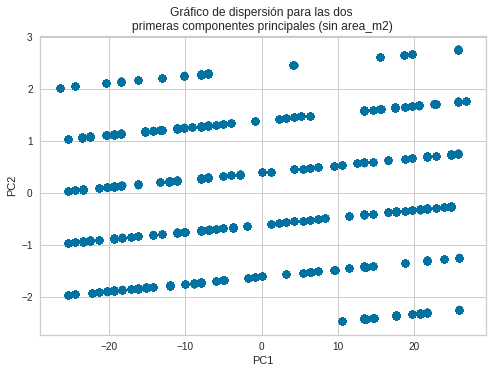

In [ ]:
plt.scatter(X_projected_a_1[:,0], X_projected_a_1[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Gráfico de dispersión para las dos \nprimeras componentes principales (sin area_m2)')
plt.show()

Con este gráfico se muestra claramente que estamos en un contexto igual que el analizado con anterioridad.

Hasta el momento no hemos podido obtener resultados significativos con técnicas de aprendizaje no supervizado. A continuación haremos un análisis similar al anterior pero sin las variables area_m2 y week.

In [ ]:
col_A_2=['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes','año']

In [ ]:
X_a_2=df_A_pca[col_A_2]

In [ ]:
#PCA sin la variable área
pca_a_2=pca.fit(X_a_2) 

# proporción de varianza
print('proporción de varianza por componente: ', pca_a_2.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca_a_2.explained_variance_ratio_.cumsum())

X_projected_a_2=pca_a_2.transform(X_a_2) #numpy array
print ('tamaño de los datos: ', X_projected_a_2.shape)

proporción de varianza por componente:  [8.66946634e-01 1.24333466e-01 7.41823048e-03 9.22563278e-04
 1.38046969e-04 9.35431806e-05]
proporción de varianza por componente acumulada:  [0.86694663 0.9912801  0.99869833 0.99962089 0.99975894 0.99985248]
tamaño de los datos:  (170090, 6)


Gráficamente:

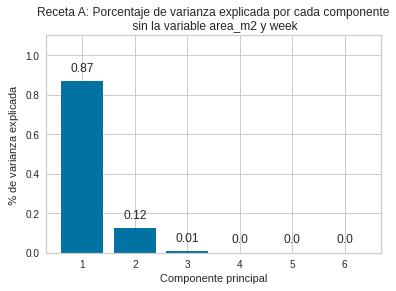

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_a_2.n_components_) + 1,
    height = pca_a_2.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_a_2.columns)) + 1, pca_a_2.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Receta A: Porcentaje de varianza explicada por cada componente\n sin la variable area_m2 y week')
ax.set_xlabel('Componente principal')
ax.set_ylabel('$\%$ de varianza explicada');

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
print('Componentes principales vistas como combinación lineal de las variables del dataset original')
pd.DataFrame(
    data    = pca_a_2.components_,
    columns = df_A_pca[col_A_2].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']
)


Componentes principales vistas como combinación lineal de las variables del dataset original


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,año
PC1,0.009536,0.016674,0.016130,-0.000074,-0.008186,0.008191,-0.002380,0.000629,-0.003334,-0.996840,0.074358
PC2,0.000651,0.004128,0.003828,-0.000316,-0.002619,-0.003458,-0.001561,-0.002535,-0.000832,-0.074250,-0.997209
PC3,-0.230186,-0.659050,-0.613984,-0.055700,0.309855,-0.142158,0.079797,0.025497,0.092600,-0.027633,-0.003747
PC4,-0.803521,0.194070,0.147335,-0.092455,-0.080908,-0.423637,0.085842,-0.297333,-0.067891,-0.004764,0.003588
PC5,-0.097619,-0.121792,-0.007183,0.951041,-0.240579,-0.074605,0.034349,0.052889,0.060665,-0.002054,-0.000092
PC6,-0.414968,-0.219017,0.069011,-0.083474,-0.290644,0.755458,0.177476,0.148169,-0.243811,0.002318,-0.003366


In [ ]:
proyecciones_df_a_2 = pd.DataFrame(
    X_projected_a_2,
    columns =  ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'],
    index   = X_a_2.index
)
proyecciones_df_a_2['espacio']=df_A_pca['espacio']
proyecciones_df_a_2['estacion']=df_A_pca['estacion']
proyecciones_df_a_2.sample(5)


,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion
41744,3.533820,0.658278,-0.386186,-0.247189,-0.056717,0.045517,1,Otoño
28940,-3.532623,1.134275,-0.128596,0.030230,0.044581,0.007761,1,Primavera
38704,5.526790,0.807338,-0.335108,-0.101516,-0.039518,0.003051,1,Verano
10148,-5.597859,1.982992,-0.255123,-0.128576,0.029286,0.012603,1,Verano
40939,3.535602,0.659504,-0.490841,-0.098518,0.014736,-0.021336,1,Verano


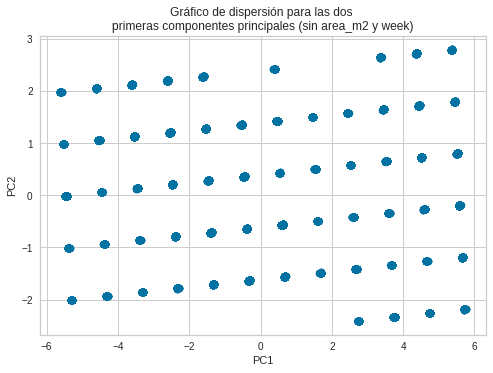

In [ ]:
plt.scatter(X_projected_a_2[:,0], X_projected_a_2[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Gráfico de dispersión para las dos \nprimeras componentes principales (sin area_m2 y week)')
plt.show()

Por conocimiento de dominio para este contexto, se sabe que las variables temporales son muy importantes en los algoritmos tanto de aprendizaje supervisado como no supervisado. Si observamos la combinación lineal de la primera componente, sin usar area_m2 y week, la variable con mayor peso es 'mes' ($\phi_{10 \ 1}=-0.97$) y si la quitamos perdemos mucha información temporal. Respecto a las variables relacionadas al tiempo, creemos que este comportamiento se debe a que los datos no están escalados, condición necesaria para aplicar un PCA. Podríamos pensar que con area_m2 sucede lo mismo, sin embargo los resultados arrojados en la próxima receta confirman que esta variable se lleva el protagonismo estén o no los datos escalados.

##Receta D con area_m2

###PCA con area_m2

In [ ]:
X_d=df_D_escal[col_D]

In [ ]:
X_d.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,area_m2,week
count,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000
mean,0.052838,0.030122,0.004519,-0.098033,0.140001,0.073043,0.036399,-0.005286,0.027300,-0.079272,0.221245,0.233175,0.267460,0.278119,0.441520,-0.009734
std,0.609094,0.762451,0.738355,0.906206,0.819951,0.675189,0.719767,0.673456,0.730911,0.514394,0.415086,0.422854,0.442636,0.448073,2.422343,0.562644
min,-1.682682,-3.312377,-2.405609,-4.043457,-3.270445,-1.588449,-1.726708,-2.121259,-2.583187,-0.857143,0.000000,0.000000,0.000000,0.000000,-0.200652,-0.928571
25%,-0.463120,-0.513375,-0.512523,-0.549272,-0.412012,-0.448985,-0.490683,-0.522834,-0.486865,-0.571429,0.000000,0.000000,0.000000,0.000000,-0.112529,-0.535714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.536880,0.486625,0.487477,0.450728,0.587988,0.551015,0.509317,0.477166,0.513135,0.428571,0.000000,0.000000,1.000000,1.000000,0.887471,0.464286
max,1.939581,3.128582,2.974983,2.986321,4.464358,2.335464,3.345756,2.096062,2.708406,0.714286,1.000000,1.000000,1.000000,1.000000,47.983402,0.928571


In [ ]:
#pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca_D=pca.fit(X_d) 

# proporción de varianza
print('proporción de varianza por componente: ', pca_D.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca_D.explained_variance_ratio_.cumsum())

X_projected_d=pca_D.transform(X_d) #numpy array
print ('tamaño de los datos: ', X_projected_d.shape)

proporción de varianza por componente:  [0.48347605 0.26659869 0.08159173 0.0654083  0.03858243 0.02087313]
proporción de varianza por componente acumulada:  [0.48347605 0.75007474 0.83166648 0.89707478 0.93565722 0.95653034]
tamaño de los datos:  (209975, 6)


Las seis primeras componentes explican el $95\%$ de la varianza de los datos.

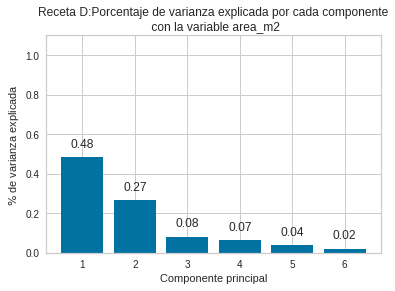

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_D.n_components_) + 1,
    height = pca_D.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_d.columns)) + 1, pca_D.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_D.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Receta D:Porcentaje de varianza explicada por cada componente\n con la variable area_m2')
ax.set_xlabel('Componente principal')
ax.set_ylabel('$\%$ de varianza explicada');

Veamos las componentes principales como combinación lineal de las variables contenidas en col_D.

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
print('Componentes principales vistas como combinación lineal de las variables del dataset original')
pd.DataFrame(
    data    = pca_D.components_,
    columns = df_D_escal[col_D].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']
)

Componentes principales vistas como combinación lineal de las variables del dataset original


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,area_m2,week
PC1,-0.007298,0.007932,0.009726,-0.023183,-0.012697,-0.001707,-0.000158,-0.013259,-0.013269,-0.000919,-0.000111,0.000927,-0.000876,0.000060,0.999366,-0.001025
PC2,-0.249261,-0.393308,-0.389128,-0.262412,0.425564,-0.286649,0.353846,0.042179,0.343236,0.121368,0.079203,-0.091042,0.067883,-0.056044,0.009496,0.133028
PC3,-0.327334,0.168161,0.149831,-0.215703,-0.126877,-0.345148,0.016130,-0.636795,-0.278436,0.143203,0.220265,0.096520,-0.047692,-0.269092,-0.024334,0.153168
PC4,0.022389,0.001477,-0.000123,0.655937,-0.058671,-0.078804,-0.019598,0.036071,0.107278,0.416616,-0.028308,-0.052766,0.321938,-0.240864,0.017582,0.455274
PC5,-0.220779,-0.122247,-0.113783,0.661573,0.054411,-0.218642,0.151914,-0.184057,0.023216,-0.322935,0.128814,0.102636,-0.330421,0.098971,0.012981,-0.356191
PC6,-0.262167,0.246951,0.210709,-0.056885,-0.280763,-0.048922,0.495401,0.205114,0.269742,-0.072730,-0.378879,0.430578,0.113174,-0.164873,-0.004999,-0.083191


Nuevamente la variable relacionada al área tiene casi todo el peso de la primera componente. Esperamos un resultado análogo al  obtenido en la receta A con area_m2.

In [ ]:
#Dataframe para alimentar a KMeans
proyecciones_df_d = pd.DataFrame(
    X_projected_d,
    columns =  ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'],
    index   = X_d.index
)
proyecciones_df_d['espacio']=df_D_escal['espacio'] #para la tabla de contingencia
proyecciones_df_d['estacion']=df_D_escal['estacion'] #para la tabla de contingencia
proyecciones_df_d.sample(5)

,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion
160627,0.430217,1.745057,-1.097360,-1.493675,0.426951,0.525788,0,Verano
73787,-0.366794,-1.826331,-0.262513,-0.070925,0.074514,0.226690,1,Otoño
201803,0.434975,-0.212940,0.095513,1.366247,-0.696008,-0.317701,0,Primavera
195210,0.393702,2.411195,-0.511043,1.266197,-0.171252,0.390901,0,Primavera
131195,-0.474232,0.526040,1.525707,-0.148982,-1.315528,1.017006,1,Primavera


Graficamente:

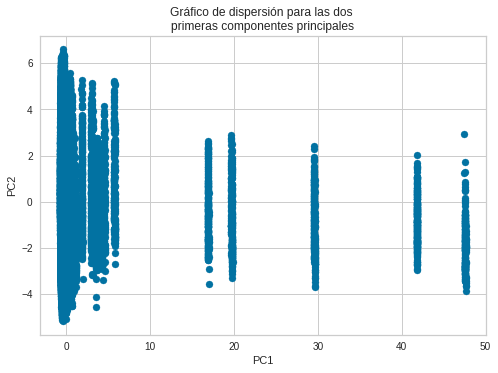

In [ ]:
plt.scatter(X_projected_d[:,0], X_projected_d[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Gráfico de dispersión para las dos \nprimeras componentes principales')
plt.show()

Vemos que por más que las variables estén escaladas, area_m2 sigue siendo determinante en peso. Notar que  si bien la varianza explicada total no depende solamente de PC1, ésta componente esta determinada por la variable área con un peso de $0.99$. Dado que en la receta A dimos un análisis más detallado de por qué es necesario prescindir de esta variable, aplicaremos KMeans eliminando 'area_m2' del dataset preparado para esta instancia.

###PCA Receta D sin area_m2

In [ ]:
col_D_1= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes','estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera',
        'estacion_Verano','week']

In [ ]:
X_d_1=df_D_escal[col_D_1]

In [ ]:
#pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca_D_1=pca.fit(X_d_1) 

# proporción de varianza
print('proporción de varianza por componente: ', pca_D_1.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca_D_1.explained_variance_ratio_.cumsum())

X_projected_d_1=pca_D_1.transform(X_d_1) #numpy array
print ('tamaño de los datos: ', X_projected_d_1.shape)

proporción de varianza por componente:  [0.51566645 0.15827159 0.12675339 0.07476609 0.04039294 0.03001451]
proporción de varianza por componente acumulada:  [0.51566645 0.67393805 0.80069144 0.87545753 0.91585047 0.94586499]
tamaño de los datos:  (209975, 6)


Las 6 primeras componentes explican el $95 \%$ de la variabilidad de los datos.

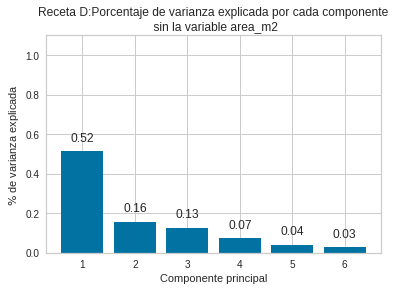

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_D_1.n_components_) + 1,
    height = pca_D_1.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_d_1.columns)) + 1, pca_D_1.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_D_1.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Receta D:Porcentaje de varianza explicada por cada componente\n sin la variable area_m2')
ax.set_xlabel('Componente principal')
ax.set_ylabel('$\%$ de varianza explicada');

In [ ]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
print('Componentes principales vistas como combinación lineal de las variables del dataset original')
pd.DataFrame(
    data    = pca_D_1.components_,
    columns = df_D_escal[col_D_1].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6']
)

Componentes principales vistas como combinación lineal de las variables del dataset original


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,week
PC1,-0.249080,-0.393415,-0.389265,-0.261922,0.425744,-0.286564,0.353804,0.042453,0.343452,0.121371,0.079180,-0.091055,0.067902,-0.056027,0.133031
PC2,-0.327724,0.168314,0.150317,-0.225267,-0.127306,-0.343766,0.016755,-0.636564,-0.279791,0.139716,0.219611,0.096454,-0.049741,-0.266325,0.149370
PC3,0.018825,0.002999,0.000928,0.656267,-0.058982,-0.083189,-0.019698,0.028481,0.104464,0.416975,-0.024933,-0.051070,0.319840,-0.243836,0.455616
PC4,-0.220691,-0.121709,-0.113675,0.658778,0.055625,-0.219282,0.150641,-0.186360,0.022007,-0.323953,0.130518,0.103483,-0.332344,0.098343,-0.357315
PC5,-0.263201,0.246460,0.210589,-0.055078,-0.281805,-0.049114,0.496520,0.205319,0.269695,-0.072954,-0.379070,0.428784,0.113497,-0.163211,-0.083432
PC6,-0.243893,0.175090,0.167983,0.008015,-0.315865,-0.071057,0.297521,0.056541,0.064487,0.031568,0.141934,-0.668660,0.072603,0.454123,0.033713


Notar que los pesos de la primera componente están mejor distribuidos y no se concentran solamente en una variable como sucedió anteriormente. Esto permite confirmar la importancia de escalar los datos y de tener presente que hay variables que por la forma en que fueron creadas pueden interferir de forma determinante en el problema que abordamos.

In [ ]:
#Dataset para alimentar a KMeans
proyecciones_df_d_1 = pd.DataFrame(
    X_projected_d_1,
    columns =  ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'],
    index   = X_d_1.index
)
proyecciones_df_d_1['espacio']=df_D_escal['espacio'] #para la tabla de contingencia
proyecciones_df_d_1['estacion']=df_D_escal['estacion'] #para la tabla de contingencia
proyecciones_df_d_1.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion
0,-2.463834,-0.542451,-0.776714,0.196898,-0.574272,0.218912,1,Verano
1,-1.104970,-1.875722,-0.352605,0.647357,-0.320525,0.083088,1,Verano
2,-0.941710,-1.810175,-0.783777,0.220337,-0.219839,0.119435,1,Verano
3,-1.063223,-2.644461,-0.644600,0.014232,-0.055558,0.105337,1,Verano
4,-0.555802,-2.561982,-0.007327,0.972683,0.132866,0.249040,1,Verano


Graficamente:

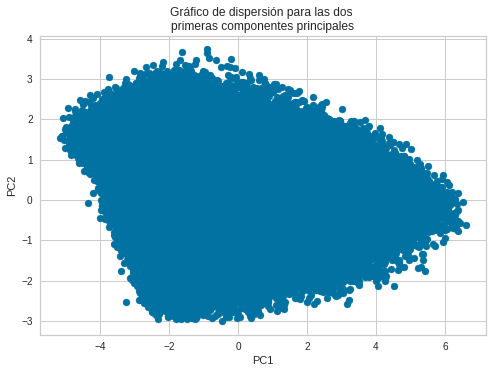

In [ ]:
plt.scatter(X_projected_d_1[:,0], X_projected_d_1[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Gráfico de dispersión para las dos \nprimeras componentes principales')
plt.show()

###KMeans Receta D

**Escenario 1**: representatividad del 80% de los datos via su varianza (explained_variance). Esto se logra con las tres primeras componentes principales.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

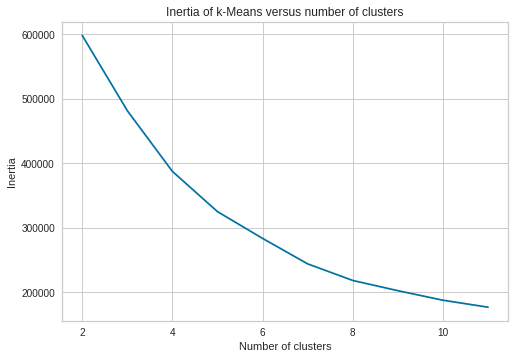

In [ ]:
#Ebowl
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i,random_state=10).fit(proyecciones_df_d_1[['PC1','PC2','PC3']]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

El codo no es tan pronunciado por lo que se dificulta elegir un valor para $k$, comenzaremos con un valor igual a $4$.

KMeans

In [ ]:
#Algoritmo KMeans

n_clust =4 #Se selecciona el número de clusters (k)

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(proyecciones_df_d_1[['PC1','PC2','PC3']]) 

clusters_d = km.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_d=proyecciones_df_d_1.copy() #Se hace una copia del df 
df_clusters_d['kmeans_clust'] = km.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km.labels_)+1, 'clusters')
df_clusters_d.head(5)

Nro Clusters encontrados:  4 clusters


,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion,kmeans_clust
0,-2.463834,-0.542451,-0.776714,0.196898,-0.574272,0.218912,1,Verano,2
1,-1.104970,-1.875722,-0.352605,0.647357,-0.320525,0.083088,1,Verano,2
2,-0.941710,-1.810175,-0.783777,0.220337,-0.219839,0.119435,1,Verano,2
3,-1.063223,-2.644461,-0.644600,0.014232,-0.055558,0.105337,1,Verano,2
4,-0.555802,-2.561982,-0.007327,0.972683,0.132866,0.249040,1,Verano,2


In [ ]:
# Predicting the clusters
labels = km.predict(proyecciones_df_d_1[['PC1','PC2','PC3']])
# Getting the cluster centers
C = km.cluster_centers_

Grafica de los clusters obtenidos

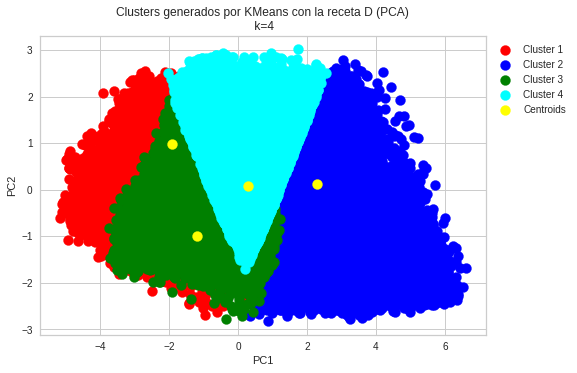

In [ ]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_d.iloc[labels == 0, 0], df_clusters_d.iloc[labels == 0, 2], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_d.iloc[labels == 1, 0], df_clusters_d.iloc[labels == 1, 2], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(df_clusters_d.iloc[labels == 2, 0], df_clusters_d.iloc[labels == 2, 2], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(df_clusters_d.iloc[labels == 3, 0], df_clusters_d.iloc[labels == 3, 2], s = 100, c = 'cyan', label = 'Cluster 4')


plt.scatter(C[:, 0], C[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta D (PCA)\n k={n_clust}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Grafica 3D

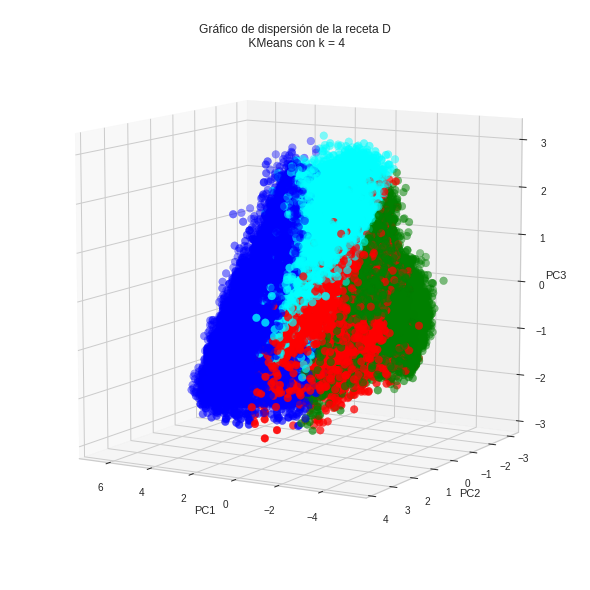

In [ ]:

colores=['red','blue','green','cyan']#, 'green']#'brown','yellow']#,'orange','cyan'
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(proyecciones_df_d_1.iloc[:, 0], proyecciones_df_d_1.iloc[:, 1],proyecciones_df_d_1.iloc[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
ax.view_init(10,120) 
#ax.view_init(10,80) 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Gráfico de dispersión de la receta D\n KMeans con k = {n_clust}')
plt.show()

**Tablas de contingencia**

Respecto al tipo de espacio:

In [ ]:
round(pd.crosstab(df_clusters_d.kmeans_clust, df_clusters_d.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.05,0.15,0.20
1,0.12,0.14,0.26
2,0.05,0.20,0.25
3,0.09,0.21,0.29
All,0.30,0.70,1.00


Vemos que estos clusters tienen espacios verdes y no verdes mezclados, si miramos la columna de espacios verdes (1) vemos que en cualquier conglomerado tenemos probabilidades condicionales no comparables entre si, es decir, no existe diferencia significativa entre ellas.

Respecto a la estación del año:

In [ ]:
round(pd.crosstab(df_clusters_d.kmeans_clust, df_clusters_d.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.04,0.13,0.02,0.01,0.20
1,0.11,0.02,0.08,0.04,0.26
2,0.00,0.04,0.00,0.20,0.25
3,0.06,0.05,0.16,0.02,0.29
All,0.22,0.23,0.27,0.28,1.00


Si utilizamos la variable 'estacion' para darle significado a las agrupaciones podemos decir que dado dada una observación en el cluster $0$, hay un $13\%$ de probabilidad que sus valores estén relacionados con índices y bandas típicos de la estación otoñal. De la misma forma le podemos dar sentido al cluster $2$ en relación al verano y al cluster $3$ respecto a la primavera.

En el cluster $1$ existe una probabilidad condicional más difusa respecto a la estación invierno y primavera, ya que hay un $11\%$ de que observaciones ubicadas en este grupo se relacionen con valores de indices y bandas asociados al invierno y un $8\%$ de que las mismas observaciones se asocien con valores relacionados con la primavera.

A pesar de este intento, los gráficos nos muestran que hay cluster como el $0$ y el $2$ que están mezclados, por lo que no podemos afirmar con seguridad que los grupos formados efectivamente tienen características propias de las observaciones relacionadas con las estaciones del año.

**Contraste con etiquetas:**

In [ ]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d.espacio, labels, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,All
grupo_real,,,,,
0,9947,25134,10356,18099,63536
1,31634,29023,42167,43615,146439
All,41581,54157,52523,61714,209975


Vemos que el procedimiento no tiene éxito al agrupar muestras del mismo espacio.

In [ ]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d.estacion, labels, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,All
grupo_real,,,,,
Invierno,9279,23634,0,13543,46456
Otoño,26521,3597,8754,10089,48961
Primavera,3321,17755,1008,34076,56160
Verano,2460,9171,42761,4006,58398
All,41581,54157,52523,61714,209975


La matriz de confusión confirma que con seguridad en el cluster 2 no hay observaciones asociadas a invierno y muy pocas asociadas a primavera. Para el resto de los casos, la agrupación no resultó buena.

**Métrica de evaluación**

In [ ]:
# Calculate Silhoutte Score
#
score = metrics.silhouette_score(proyecciones_df_d_1[['PC1','PC2','PC3']], km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.290


Como la puntuación es más cercana a 0 que a 1 significa que los clústeres se superponen, tal como lo muestra el gráfico y las tablas de contingencia.

Como conclusión parcial, podemos decir que con un $k=4$ los conglomerados no parecen ser interpretables en función de las variables 'espacio' y 'estación'. El método del codo utilizando la inercia podría no ser un buen indicador para la elección de $k$ en nuestra situación, por lo que vamos a acudir a utilizar la puntuación de silhouette para decidir un mejor valor para este hiperparámetro.

In [ ]:
#NO CORRER... O ESPERAR
K = np.arange(2,11)

lista_sil = []

for k in range(2,11):
    km = KMeans(n_clusters=k)
    km = km.fit(proyecciones_df_d_1[['PC1','PC2','PC3']])
    
    etiquetas = km.labels_
    
    valor_medio_sil = silhouette_score(proyecciones_df_d_1[['PC1','PC2','PC3']], etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil, c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para la receta D')

plt.show()

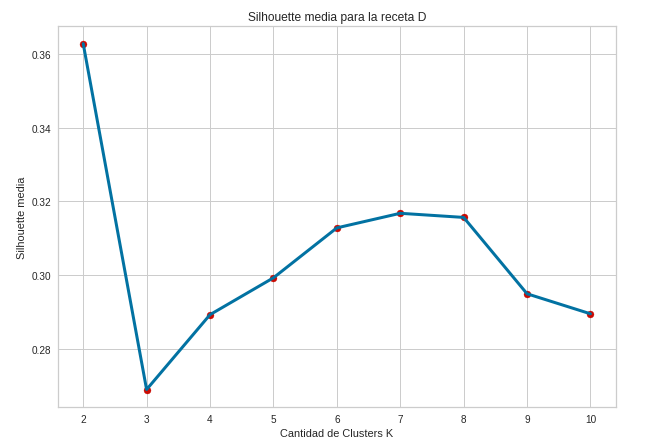

Tal como muestra el gráfico de silueta, el $k=2$ sería el valor óptimo. A continuación realizamos KMeans, en este mismo escenario y usando este valor de $k$.

**Escenario 1* ($k$ mejorado)**: representatividad del 80% de los datos via su varianza (explained_variance). Esto se logra con las tres primeras componentes principales. 

In [ ]:
n_clust =2 #Se selecciona el número de clusters (k)

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(proyecciones_df_d_1[['PC1','PC2','PC3']]) 

clusters_d_1 = km.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_d_1=proyecciones_df_d_1.copy() #Se hace una copia del df 
df_clusters_d_1['kmeans_clust'] = km.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km.labels_)+1, 'clusters')
df_clusters_d_1.head(5)

Nro Clusters encontrados:  2 clusters


,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion,kmeans_clust
0,-2.463834,-0.542451,-0.776714,0.196898,-0.574272,0.218912,1,Verano,1
1,-1.104970,-1.875722,-0.352605,0.647357,-0.320525,0.083088,1,Verano,1
2,-0.941710,-1.810175,-0.783777,0.220337,-0.219839,0.119435,1,Verano,1
3,-1.063223,-2.644461,-0.644600,0.014232,-0.055558,0.105337,1,Verano,1
4,-0.555802,-2.561982,-0.007327,0.972683,0.132866,0.249040,1,Verano,1


Graficamente

In [ ]:
# Predicting the clusters
labels_1 = km.predict(proyecciones_df_d_1[['PC1','PC2','PC3']])
# Getting the cluster centers
C_1 = km.cluster_centers_

2D

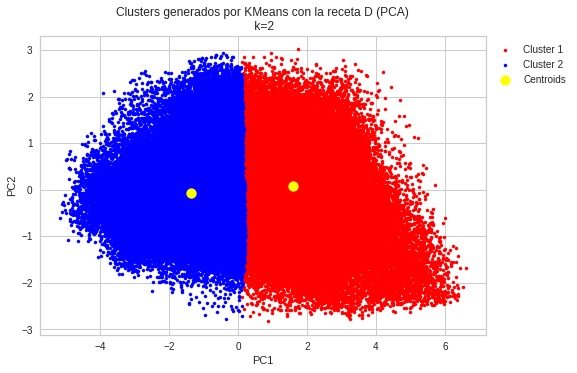

In [ ]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_d_1.iloc[labels_1 == 0, 0], df_clusters_d_1.iloc[labels_1 == 0, 2], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_d_1.iloc[labels_1 == 1, 0], df_clusters_d_1.iloc[labels_1 == 1, 2], s = 10, c = 'blue', label = 'Cluster 2')
# plt.scatter(df_clusters_d_1.iloc[labels == 2, 0], df_clusters_d_1.iloc[labels == 2, 2], s = 10, c = 'green', label = 'Cluster 3')
# plt.scatter(df_clusters_d_1.iloc[labels == 3, 0], df_clusters_d_1.iloc[labels == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(C_1[:, 0], C_1[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta D (PCA)\n k={n_clust}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

3D

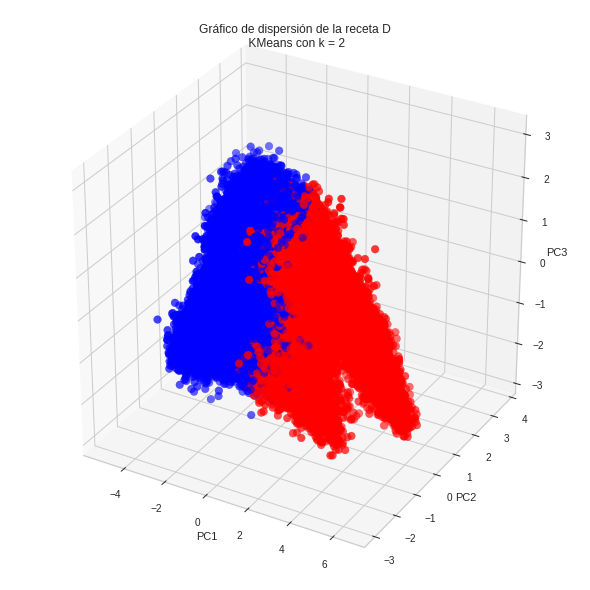

In [ ]:

colores=['red','blue']#,'green','cyan', 'green','brown','yellow']#,'orange','cyan'
asignar=[]
for row in labels_1:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(proyecciones_df_d_1.iloc[:, 0], proyecciones_df_d_1.iloc[:, 1],proyecciones_df_d_1.iloc[:, 2], c=asignar,s=60)
ax.scatter(C_1[:, 0], C_1[:, 1], C_1[:, 2], marker='*', c=colores, s=1000)
#ax.view_init(10,120) 
#ax.view_init(10,80) 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Gráfico de dispersión de la receta D\n KMeans con k = {n_clust}')
plt.show()

In [ ]:
round(pd.crosstab(df_clusters_d_1.kmeans_clust, df_clusters_d_1.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.19,0.27,0.46
1,0.11,0.43,0.54
All,0.30,0.70,1.00


Claramente, no podemos caracterizar los clusters por tipo de espacio.

In [ ]:
round(pd.crosstab(df_clusters_d_1.kmeans_clust, df_clusters_d_1.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.16,0.04,0.18,0.08,0.46
1,0.06,0.19,0.08,0.20,0.54
All,0.22,0.23,0.27,0.28,1.00


Podríamos pensar que el el cluster $0$ encontramos, en su mayoría, valores de bandas e índices relacionados a invierno y primavera y en el $1$ cantidades asociadas a verano y otoño. Aunque de ser así, serian valores asociados a los cambios de estación y no a cada estación en sí.

**Métrica de evaluación**

Como nos mostró el gráfico de silueta, elegir un $k=2$ nos da una puntuación del $0.37$ aproximadamente, lo cual se ve mejorado respecto a $k=4$ cuya puntuación es de $0.29$.

**Escenario 2**: representatividad del 95% de los datos via su varianza (explained_variance). Esto se logra con las 6 primeras componentes principales. 

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

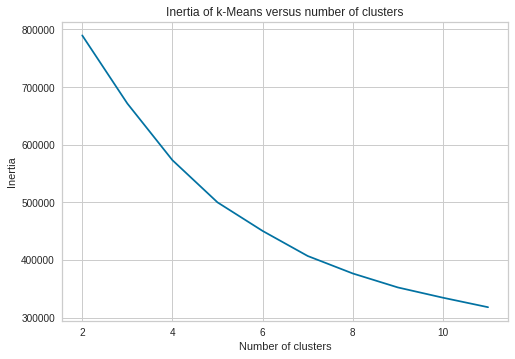

In [ ]:
#Ebowl
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i,random_state=10).fit(proyecciones_df_d_1[['PC1','PC2','PC3','PC4','PC5','PC6']]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Nuevamente, el codo no es pronunciado por lo que se dificulta elegir un $k$ óptimo, siguiendo la línea anterior tomaremos $k=2$. Ya sabemos de antemano que los conglomerados no giran, en un principio, en torno a la variable 'espacio'.

KMeans

In [ ]:
#Algoritmo KMeans

n_clust =2 #Se selecciona el número de clusters (k)

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(proyecciones_df_d_1[['PC1','PC2','PC3','PC4','PC5','PC6']]) 

df_clusters_d_2 = km.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_d_2=proyecciones_df_d_1.copy() #Se hace una copia del df 
df_clusters_d_2['kmeans_clust'] = km.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km.labels_)+1, 'clusters')
df_clusters_d_2.head(5)

Nro Clusters encontrados:  2 clusters


,PC1,PC2,PC3,PC4,PC5,PC6,espacio,estacion,kmeans_clust
0,-2.463834,-0.542451,-0.776714,0.196898,-0.574272,0.218912,1,Verano,0
1,-1.104970,-1.875722,-0.352605,0.647357,-0.320525,0.083088,1,Verano,0
2,-0.941710,-1.810175,-0.783777,0.220337,-0.219839,0.119435,1,Verano,0
3,-1.063223,-2.644461,-0.644600,0.014232,-0.055558,0.105337,1,Verano,0
4,-0.555802,-2.561982,-0.007327,0.972683,0.132866,0.249040,1,Verano,0


Gráficamente

In [ ]:
# Predicting the clusters
labels_2 = km.predict(proyecciones_df_d_1[['PC1','PC2','PC3','PC4','PC5','PC6']])
# Getting the cluster centers
C_2 = km.cluster_centers_

En 2D

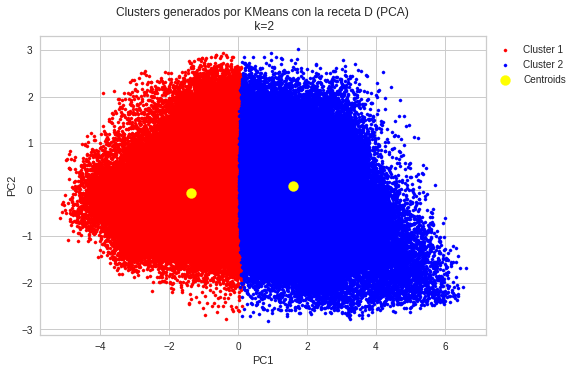

In [ ]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_d_2.iloc[labels_2 == 0, 0], df_clusters_d_2.iloc[labels_2 == 0, 2], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_d_2.iloc[labels_2 == 1, 0], df_clusters_d_2.iloc[labels_2 == 1, 2], s = 10, c = 'blue', label = 'Cluster 2')
# plt.scatter(df_clusters_d_1.iloc[labels == 2, 0], df_clusters_d_1.iloc[labels == 2, 2], s = 10, c = 'green', label = 'Cluster 3')
# plt.scatter(df_clusters_d_1.iloc[labels == 3, 0], df_clusters_d_1.iloc[labels == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(C_2[:, 0], C_2[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta D (PCA)\n k={n_clust}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

En 3D

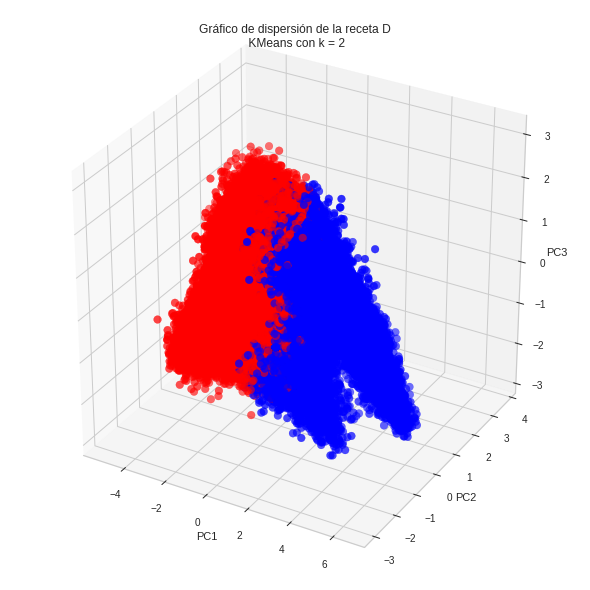

In [ ]:

colores=['red','blue']#,'green','cyan'] #'green','brown','yellow','orange','cyan'
asignar=[]
for row in labels_2:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(proyecciones_df_d_1.iloc[:, 0], proyecciones_df_d_1.iloc[:, 1],proyecciones_df_d_1.iloc[:, 2], c=asignar,s=60)
ax.scatter(C_2[:, 0], C_2[:, 1], C_2[:, 2], marker='*', c=colores, s=1000)
#ax.view_init(10,150) 
#ax.view_init(10,80) 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'Gráfico de dispersión de la receta D\n KMeans con k = {n_clust}')
plt.show()

**Tablas de contingencia**

Por espacio

In [ ]:
round(pd.crosstab(df_clusters_d_2.kmeans_clust, df_clusters_d_2.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.11,0.43,0.54
1,0.19,0.27,0.46
All,0.30,0.70,1.00


Al igual que el caso anterior, estos clusters no tienen que ver con espacios verdes/no verdes.

Por estacion

In [ ]:
round(pd.crosstab(df_clusters_d_2.kmeans_clust, df_clusters_d_2.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.06,0.19,0.09,0.20,0.54
1,0.16,0.04,0.18,0.08,0.46
All,0.22,0.23,0.27,0.28,1.00


Las conclusiones son las mismas que las que obtuvimos en el escenario 1 con $k=2$.

In [ ]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d_1.estacion, labels_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
Invierno,34091,12365,46456
Otoño,8558,40403,48961
Primavera,38319,17841,56160
Verano,16310,42088,58398
All,97278,112697,209975


In [ ]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d_1.espacio, labels_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
0,40815,22721,63536
1,56463,89976,146439
All,97278,112697,209975


**Métrica de evaluación**

In [ ]:
# Calculate Silhoutte Score k=2 y 6 componentes principales (95% varianza explicada)
#
score = metrics.silhouette_score(proyecciones_df_d_1[['PC1','PC2','PC3','PC4','PC5','PC6']], labels_2, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.307


Esta puntuación nos dice que los cluster se superponen para una cantidad considerable de observaciones. Respecto la puntuación de silueta obtenida en el escenario 1 con $k=2$, en la situación 2 éste score no se vió mejorado ($0.37$ vs. $0.31$).

###Análisis de ejemplos aleatorios

Esto también ayuda a responder:
- ¿Existe alguna forma de ayudar a que las zonas diferenciadas emerjan en una forma mas accesible (ayuda: pensar en indices, NDWI, NDVI,etc).

Vamos a analizar ejemplos aleatorios de los resultados obtenidos con KMeans ($k=2$) aplicado a las 3 primeras componentes principales, ya que el coeficiente de silueta fue mayor en este caso (escenario 2*)

In [ ]:
# df=pd.concat([df_D_escal[['raster']],X_d_1[['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
#         'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median']],df_clusters_d[['espacio','estacion','kmeans_clust']]], axis=1, ignore_index= False)
# df.head(5)
# #'PC1','PC2','PC3',

In [ ]:
df=pd.concat([df_D_escal[['raster']],df_clusters_d_1[['PC1','PC2','PC3','espacio','estacion','kmeans_clust']]], axis=1, ignore_index= False)
df.head(5)

,raster,PC1,PC2,PC3,espacio,estacion,kmeans_clust
0,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,-2.463834,-0.542451,-0.776714,1,Verano,1
1,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,-1.104970,-1.875722,-0.352605,1,Verano,1
2,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,-0.941710,-1.810175,-0.783777,1,Verano,1
3,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,-1.063223,-2.644461,-0.644600,1,Verano,1
4,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,-0.555802,-2.561982,-0.007327,1,Verano,1


Además de la tabla de contingencia, podemos utilizar el coeficiente de correlación entre las componentes principales y las variables del dataset original para darle sentido a los clusters (o intentarlo). La matriz de correlación que representa esta situación es la que sigue

In [ ]:
df_correlaciones_d=pd.concat([X_d_1[['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median','mes']], proyecciones_df_d_1[['PC1','PC2','PC3']]], axis=1, ignore_index= False)
df_correlaciones_d.head(5)

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,mes,PC1,PC2,PC3
0,0.929340,0.778555,0.766081,0.345414,-0.589862,0.992120,-0.991718,-0.110236,-0.931698,-0.857143,-2.463834,-0.542451,-0.776714
1,0.869643,0.040574,0.044745,0.807584,-0.016520,0.814113,-0.559006,0.966929,0.232925,-0.857143,-1.104970,-1.875722,-0.352605
2,0.828132,0.032768,0.035832,0.187248,-0.009054,0.926890,-0.405797,1.102362,0.096322,-0.857143,-0.941710,-1.810175,-0.783777
3,1.146289,0.079950,0.084637,0.330829,-0.053624,1.228783,-0.457557,1.910235,0.452714,-0.857143,-1.063223,-2.644461,-0.644600
4,0.749518,-0.104207,-0.112267,1.220481,0.128096,0.686655,-0.080745,1.666141,0.851138,-0.857143,-0.555802,-2.561982,-0.007327


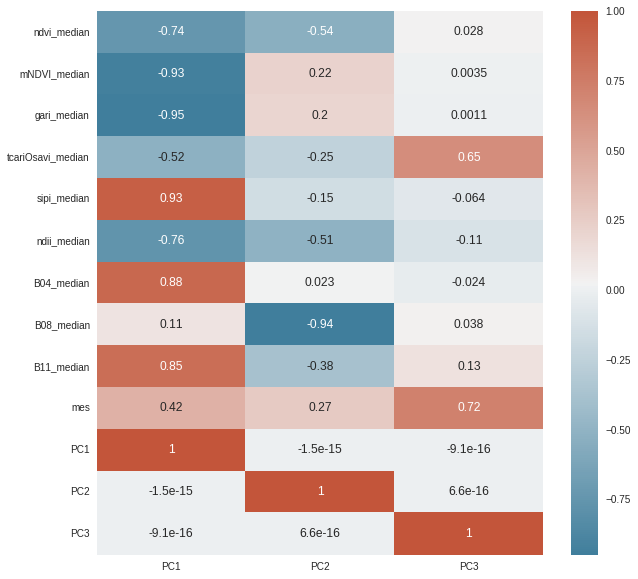

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
target_corr = pd.DataFrame(df_correlaciones_d.corr()[['PC1','PC2','PC3']], index=df_correlaciones_d.corr().index)

plt.figure(figsize=(10,10))
sns.heatmap(target_corr, annot=True, cmap=cmap)

plt.show()

Interpretación del heatmap: para esto miramos aquellas valores de correlación de Pearson mayores a $0.65$ en valor absoluto.

  * PC1:
     - Valores bajos en PC1 implica:
- Valores bajos de sipi_median ($\rho=0.93$)
- Valores bajos de B04_median ($\rho=0.88$) 
- Valores bajos de B11_median ($\rho=0.85$)

     - Los valores bajos en PC1 implican:
- Valores altos de ndvi_median ($\rho=-0.74$)
- Valores altos de ndii_median ($\rho=-0.76$)
- Valores altos de  mNDVI ($\rho=-0.93$)
- Valores altos de gari_median ($\rho=-0.95$)

  * PC2:
     - Valores bajos en PC2 implica:
- Valores altos de B08_median ($\rho=-0.94$)

  * PC3:
     - Valores bajos en PC3 implica:
- Valores bajos en los meses ($\rho=0.72$)
- Valores bajos en tcariOsavi_median ($\rho=0.65$)


Ahora analicemos algunos ejemplos aleatorios de cada cluster para intentar acercarnos a una caracterización. Para esto utilizaremos la media de cada componente, según el cluster que estemos analizando.

- Muestra aleatoria del cluster $0$

In [ ]:
df[df['kmeans_clust']==0].sample(5)

,raster,PC1,PC2,PC3,espacio,estacion,kmeans_clust
129001,S2B_MSIL1C_20191214T141729_N0208_R010_T20JLL_2...,0.442887,-0.148558,1.237328,1,Primavera,0
155134,S2B_MSIL1C_20200103T141729_N0208_R010_T20JLL_2...,0.406187,-1.491473,-1.308178,0,Verano,0
179868,S2A_MSIL1C_20170821T142041_N0205_R010_T20JLL_2...,0.453562,1.239283,0.520924,0,Invierno,0
94639,S2B_MSIL1C_20200810T141739_N0209_R010_T20JLL_2...,3.551725,0.590443,-1.300459,1,Invierno,0
199132,S2A_MSIL1C_20181214T142031_N0207_R010_T20JLL_2...,2.073295,-0.434215,1.556710,0,Primavera,0


In [ ]:
#print(df_clusters_d.espacio.value_counts())
print(df[df['kmeans_clust']==0][['espacio']].value_counts())
print('--------------------')
print(df[df['kmeans_clust']==0][['estacion']].value_counts())


espacio
1          56463
0          40815
dtype: int64
--------------------
estacion 
Primavera    38319
Invierno     34091
Verano       16310
Otoño         8558
dtype: int64


In [ ]:
df[df['kmeans_clust']==0][['PC1','PC2','PC3']].describe()

,PC1,PC2,PC3
count,97278.000000,97278.000000,97278.000000
mean,1.587261,0.072029,0.034983
std,1.118416,0.834238,0.965160
min,0.015270,-2.924216,-2.822285
25%,0.673199,-0.533467,-0.676506
50%,1.356508,0.035425,0.076135
75%,2.253146,0.697693,0.810154
max,6.603933,3.172368,3.011482



El resumen muestra, en promedio, valores más altos para PC1, PC2 y PC3. Segun el heatmap, esto implica valores altos en sipi_median, en B04_median y B11_median y, además valores bajos de ndvi_median, ndii_median, mNDVI y gari_median. Por otro lado estamos interpretando valores altos de tcariOsavi_median.




---


El NDVI es sensible a los efectos del suelo y la atmósfera es, por ello, que se recomienda aplicar índices adicionales para un análisis más preciso de la vegetación

NDVI Tiene el inconveniente de ser sensible a la
reflectividad del suelo sobre el que se sitúa la planta, lo que limita su potencial de discriminación.

El SIPI o Índice de Pigmentación Insensible a la Estructura es bueno para el análisis de la vegetación con la estructura variable del dosel. Estima la relación de carotenoides a clorofila: las señales de mayor valor de la vegetación estresada.






- Muestra aleatoria del cluster $1$

In [ ]:
# df[df['kmeans_clust']==0].groupby(by=['espacio','estacion'])[['kmeans_clust']].count()
df[df['kmeans_clust']==1].sample(5)

,raster,PC1,PC2,PC3,espacio,estacion,kmeans_clust
145687,S2A_MSIL1C_20211128T141741_N0301_R010_T20JLL_2...,-1.397833,-1.396778,1.556343,1,Primavera,1
8685,S2A_MSIL1C_20180227T142031_N0206_R010_T20JLL_2...,-0.090905,-1.077552,-0.991550,1,Verano,1
108984,S2B_MSIL1C_20171015T142029_N0205_R010_T20JLL_2...,-0.231934,0.964885,0.796698,1,Primavera,1
113941,S2A_MSIL1C_20181005T142031_N0206_R010_T20JLL_2...,-0.437953,0.492609,1.243276,1,Primavera,1
24835,S2B_MSIL1C_20200222T141649_N0209_R010_T20JLL_2...,-1.378221,-0.892021,-0.570478,1,Verano,1


In [ ]:
#print(df_clusters_d.espacio.value_counts())
print(df[df['kmeans_clust']==1][['espacio']].value_counts())
print('--------------------')
print(df[df['kmeans_clust']==1][['estacion']].value_counts())

espacio
1          89976
0          22721
dtype: int64
--------------------
estacion 
Verano       42088
Otoño        40403
Primavera    17841
Invierno     12365
dtype: int64


In [ ]:
df[df['kmeans_clust']==1][['PC1','PC2','PC3']].describe()

,PC1,PC2,PC3
count,112697.000000,112697.000000,112697.000000
mean,-1.370095,-0.062174,-0.030196
std,0.950663,1.115050,0.823088
min,-5.160726,-3.005514,-2.773242
25%,-1.992674,-0.958995,-0.652628
50%,-1.249779,-0.164878,-0.164691
75%,-0.597282,0.784074,0.472467
max,0.219741,3.729796,2.942684


El resumen muestra, en promedio, valores bajos para PC1, PC2 y PC3. Segun el heatmap, esto implica valores bajos de sipi_median, en B04_median y B11_median y, además valores altos de ndvi_median, ndii_median, mNDVI y gari_median. Por otro lado estamos interpretando valores bajos de tcariOsavi_median.






* Matriz de confusión



Esto también ayuda a  responder:

- Contrastar la clasificación en clusters con las etiquetas de clases, tanto gráficamente como analítica. 
- Dada la naturaleza del problema, puede pensar en elaborar una matriz confusion para presentar parte de la solución, cuales clases utilizaria?

- ¿Podríamos utilizar este enfoque para complementar/ayudar en el proceso de etiquetado?

- ¿Este esquema no supervisado podría servir para cotejar resultados supervisados?

Para los espacios

In [ ]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d_1.espacio, labels_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
0,40815,22721,63536
1,56463,89976,146439
All,97278,112697,209975


In [ ]:
from sklearn import metrics 
print(metrics.classification_report(df_clusters_d_1.espacio, labels_1))
 

#accuracy_score(y_true, y_pred, normalize=False)

              precision    recall  f1-score   support

           0       0.42      0.64      0.51     63536
           1       0.80      0.61      0.69    146439

    accuracy                           0.62    209975
   macro avg       0.61      0.63      0.60    209975
weighted avg       0.68      0.62      0.64    209975



Para las estaciones (esto es una tabla de contingencia, donde la probabilidades condicionales se leen en sentido opuesto a como lo veníamos haciendo)

In [ ]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_d_1.estacion, labels_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True, normalize=True)

cluster,0,1,All
grupo_real,,,
Invierno,0.162357,0.058888,0.221245
Otoño,0.040757,0.192418,0.233175
Primavera,0.182493,0.084967,0.267460
Verano,0.077676,0.200443,0.278119
All,0.463284,0.536716,1.000000


Estas tablas de contingencia permiten confirmar que definitivamente no podemos caracterizar a los clusters ni por la estación (o cambio de estaciones seguidas) ni por tipo de espacio. Si pudieramos decir que el cluster $0$ corresponde a observaciones de invierno y primavera, en el cluster $1$ habría muchos falsos negativos. El mismo análisis podríamos hacer si pudieramos afirmar que en el cluster 1 podemos encontrar observaciones características de la estación otoño y verano.